## Load and Explore Data

In [13]:
%pip install matplotlib
%pip install seaborn

You should consider upgrading via the '/Users/marcelomartinez/GitHub/mlip-project/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/marcelomartinez/GitHub/mlip-project/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
ratings = pd.read_csv("../data/raw/ml-100k/u.data", sep="\t", header=None,names=["user_id", "movie_id", "rating", "timestamp"])

In [16]:
movies = pd.read_csv("../data/raw/ml-100k/u.item", sep="|", header=None, encoding='latin-1',
                     names=["movie_id", "title", "release_date", "video_release_date",
                            "IMDb_URL", "unknown", "Action", "Adventure", "Animation",
                            "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
                            "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
                            "Thriller", "War", "Western"])

In [17]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [18]:
print("Number of ratings:", len(ratings))
print("Number of unique users:", ratings['user_id'].nunique())
print("Number of unique movies:", ratings['movie_id'].nunique())
ratings.describe()


Number of ratings: 100000
Number of unique users: 943
Number of unique movies: 1682


,user_id,movie_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


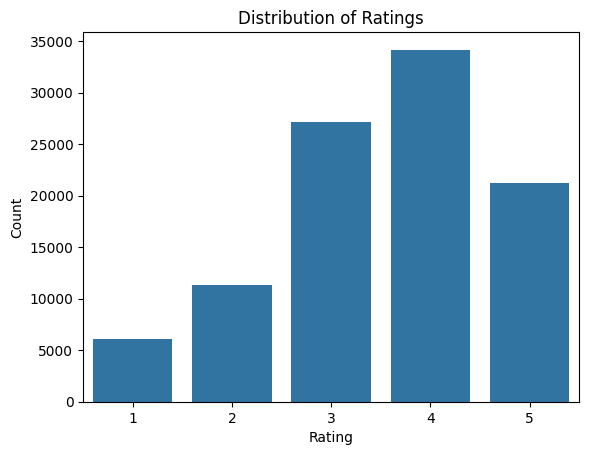

In [19]:
sns.countplot(x='rating', data=ratings)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


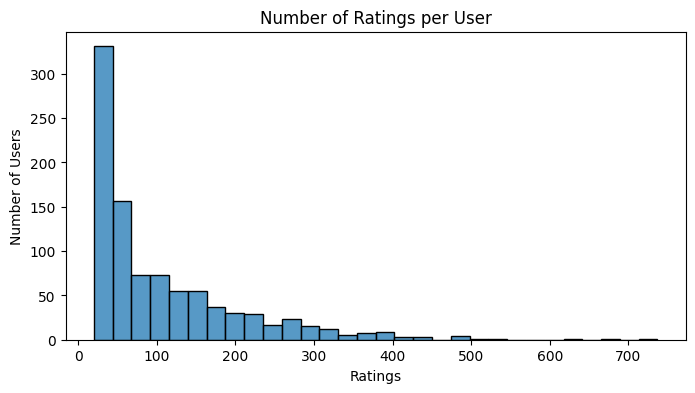

Avg. ratings per user: 106.04453870625663


In [20]:
ratings_per_user = ratings.groupby('user_id')['movie_id'].count()

plt.figure(figsize=(8,4))
sns.histplot(ratings_per_user, bins=30)
plt.title("Number of Ratings per User")
plt.xlabel("Ratings")
plt.ylabel("Number of Users")
plt.show()

print("Avg. ratings per user:", ratings_per_user.mean())


## Feature Engineer

In [21]:
user_features = ratings.groupby('user_id').agg(
    user_num_ratings=('movie_id', 'count'),
    user_avg_rating=('rating', 'mean')
).reset_index()

user_features.head()


,user_id,user_num_ratings,user_avg_rating
0,1,272,3.610294
1,2,62,3.709677
2,3,54,2.796296
3,4,24,4.333333
4,5,175,2.874286


In [22]:
movie_features = ratings.groupby('movie_id').agg(
    movie_num_ratings=('user_id', 'count'),
    movie_avg_rating=('rating', 'mean')
).reset_index()

movie_features = pd.merge(movie_features, movies[['movie_id', 'title']], on='movie_id')
movie_features.head()


,movie_id,movie_num_ratings,movie_avg_rating,title
0,1,452,3.878319,Toy Story (1995)
1,2,131,3.206107,GoldenEye (1995)
2,3,90,3.033333,Four Rooms (1995)
3,4,209,3.550239,Get Shorty (1995)
4,5,86,3.302326,Copycat (1995)


Genres: ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


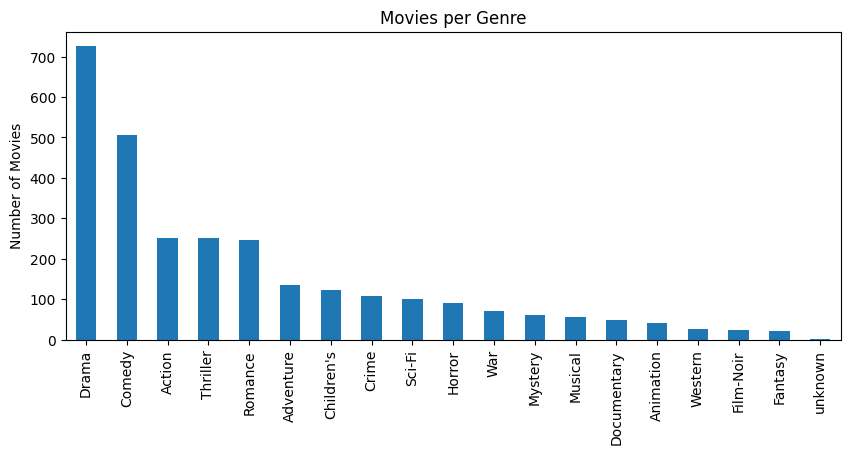

In [23]:
genre_columns = movies.columns[5:]

# Just double-check how genres look
print("Genres:", genre_columns.tolist())

# Count how many movies per genre
movies[genre_columns].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,4))
plt.title("Movies per Genre")
plt.ylabel("Number of Movies")
plt.show()


In [24]:
# Merge everything into ratings
merged = ratings.copy()
merged = merged.merge(user_features, on='user_id', how='left')
merged = merged.merge(movie_features.drop(columns=['title']), on='movie_id', how='left')
merged = merged.merge(movies[['movie_id'] + list(genre_columns)], on='movie_id', how='left')

merged.head()


,user_id,movie_id,rating,timestamp,user_num_ratings,user_avg_rating,movie_num_ratings,movie_avg_rating,unknown,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,39,3.615385,117,3.991453,0,0,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,92,3.413043,297,4.161616,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,878887116,128,3.351562,13,2.153846,0,0,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,880606923,238,3.651261,81,3.456790,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,886397596,20,3.550000,126,3.642857,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
merged.to_csv("../data/processed/ratings_with_features.csv", index=False)


### Collaborative Filtering with surprise

In [26]:
%pip install numpy==1.24.4
%pip install scikit-surprise

You should consider upgrading via the '/Users/marcelomartinez/GitHub/mlip-project/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/marcelomartinez/GitHub/mlip-project/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [27]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

# Prepare the dataset: Surprise expects specific format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["user_id", "movie_id", "rating"]], reader)

# Split into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


In [34]:
# Use SVD (Matrix Factorization)
model = SVD()

# Train on the training set
model.fit(trainset)

# Predict on the test set
predictions = model.test(testset)

# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)


RMSE: 0.9388
MAE:  0.7404


In [44]:
import os
import pickle
os.makedirs("../models", exist_ok=True)

with open("../models/svd_model.pkl", "wb") as f:
    pickle.dump(model, f)


In [32]:
# Get a list of all movie IDs
all_movie_ids = ratings['movie_id'].unique()

# Pick a user
user_id = 45

# Find which movies the user hasn't rated yet
rated_movies = ratings[ratings['user_id'] == user_id]['movie_id']
unrated_movies = [movie for movie in all_movie_ids if movie not in rated_movies.values]

# Predict ratings for the unrated movies
predictions = [model.predict(user_id, movie_id) for movie_id in unrated_movies]

# Sort by estimated rating
top_recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:10]

# Display titles
for pred in top_recommendations:
    movie_title = movies[movies['movie_id'] == pred.iid]['title'].values[0]
    print(f"{movie_title} (predicted rating: {pred.est:.2f})")


Close Shave, A (1995) (predicted rating: 5.00)
Titanic (1997) (predicted rating: 4.90)
Casablanca (1942) (predicted rating: 4.84)
Raiders of the Lost Ark (1981) (predicted rating: 4.75)
Wrong Trousers, The (1993) (predicted rating: 4.74)
Empire Strikes Back, The (1980) (predicted rating: 4.73)
Schindler's List (1993) (predicted rating: 4.72)
Amadeus (1984) (predicted rating: 4.72)
African Queen, The (1951) (predicted rating: 4.71)
Citizen Kane (1941) (predicted rating: 4.70)


### Content-Based Filtering Model

In [35]:
# We already have one-hot genre columns in movies
genre_columns = movies.columns[5:]

# Create the content feature matrix
movie_features = movies.set_index('movie_id')[genre_columns]

movie_features.head()


,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [36]:
def get_user_top_movies(user_id, min_rating=4):
    top_movies = ratings[(ratings['user_id'] == user_id) & (ratings['rating'] >= min_rating)]
    return top_movies['movie_id'].values

user_id = 42
user_top_movies = get_user_top_movies(user_id)
print("User has rated these movies highly:", user_top_movies)


User has rated these movies highly: [ 423   96  274  588 1028   98  685  195  185   69  684  603 1041  121
  143   48  999  102  210  785  405  845  781  380  357  204  404  142
  692   99 1051  222  925  568  211   12   82   88   28  939  418 1044
  736  183   79  234  280  732  196  172  194  496  215  742  566   63
  118  479  216   95  230   77  866    1  371 1047  427   15  469  229
  173   83  385  228   54  756  720  934   58  125  161  202  471  237
  501  402  419   66  203  135   64  468  239  523  227  294  369  151
  318   50   71  941  969  132  181  174   73    2  755  282  136  735
  411   87  591]


In [37]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Get genre vectors of the movies the user liked
user_profile = movie_features.loc[user_top_movies].mean(axis=0).values.reshape(1, -1)

# Compute cosine similarity to all movies
similarities = cosine_similarity(user_profile, movie_features.values)[0]

# Create DataFrame with similarity scores
movie_scores = pd.DataFrame({
    'movie_id': movie_features.index,
    'similarity': similarities
})


In [42]:
# Remove movies the user has already rated
seen_movies = ratings[ratings['user_id'] == user_id]['movie_id']
recommendations = movie_scores[~movie_scores['movie_id'].isin(seen_movies)]

# Sort by similarity score
recommendations = recommendations.sort_values(by='similarity', ascending=False).head(10)

# Join with movie titles
top_recommendations = pd.merge(recommendations, movies[['movie_id', 'title']], on='movie_id')

top_recommendations[['title', 'similarity']]


,title,similarity
0,Faster Pussycat! Kill! Kill! (1965),0.750778
1,Get Shorty (1995),0.750778
2,Manhattan (1979),0.730115
3,I Like It Like That (1994),0.730115
4,Wings of Desire (1987),0.730115
5,Twelfth Night (1996),0.730115
6,What Happened Was... (1994),0.730115
7,Something to Talk About (1995),0.730115
8,"Corrina, Corrina (1994)",0.730115
9,Brassed Off (1996),0.730115


### Comparison of Collaborative Filtering vs. Content-Based Filtering

| Feature                       | Collaborative Filtering (SVD)      | Content-Based Filtering               |
|------------------------------|------------------------------------|---------------------------------------|
| Based on                     | User–item rating patterns          | Movie content (genres)                |
| Uses other users' preferences| Yes                                | No                                    |
| Needs movie metadata         | No                                 | Yes                                   |
| Handles cold-start users     | No                                 | Yes (if user rated a few movies)      |
| Predicts ratings             | Yes (e.g., 4.3 stars)              | No (recommends based on similarity)   |
| Learns hidden preferences    | Yes                                | No                                    |
| Easy to interpret            | No                                 | Yes (based on genres)                 |
| Suitable for diverse tastes  | Yes                                | Limited to user’s past interests      |
| Performance (on ML-100k)     | RMSE ≈ 0.936, MAE ≈ 0.738          | N/A                                   |
